## LlamaParse with AutoMode :

I enabled the **AutoMode** by setting it to **true**, which defaults to the standard parsing mode. However, I added triggers for tables and images to switch to the **Premium mode** for **advanced parsing** when needed.

This setup ensures that advanced parsing is applied only on pages with tables and images, while standard parsing handles the rest efficiently.

## LLMs:
I used OpenAI embedding model **text-embedding-3-small** and **gpt-4o-mini** to generate the final output.

## Use case
I uploaded Meta's 2023 10-K financial report, a 147-page document containing a mix of tables, charts, and text-only pages. This serves as an excellent example to demonstrate the effectiveness of using LlamaParse AutoMode.


## RAG Pipelines:
I used two RAG pipelines: Simple and Advanced

1.   Simple one: just one VectorStoreIndex to embedd the content for retrieval (with top similarity=5)
2.   Advanced one: I used  two types of indexes: the **SummaryIndex** for summarizing content and the **VectorStoreIndex** for retrieving relevant chunks based on user queries.

Additionally, I implemented a **router** to determine which index to use based on the nature of the user query


## Key Takeways:

You can see clearly which page is triggered or not by the AutoMode.

The data are well extracted even for complicated charts.

The RAG pipelines are efficient with good quality input data.



[Hanane Dupouy](https://www.linkedin.com/in/hanane-d-algo-trader)

In [ ]:
!pip install llama-index llama-index-core llama-index-embeddings-openai llama-index-llms-openai llama-parse -q

In [2]:
import nest_asyncio

nest_asyncio.apply()

In [3]:
from google.colab import userdata
LLAMACLOUD_API_KEY = userdata.get('LLAMACLOUD_API_KEY')
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

import os
os.environ["LLAMA_CLOUD_API_KEY"] = LLAMACLOUD_API_KEY

# Using OpenAI API for embeddings/llms
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [5]:
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import VectorStoreIndex
from llama_index.core import Settings

embed_model = OpenAIEmbedding(model="text-embedding-3-small")
llm = OpenAI(model="gpt-4o-mini")

Settings.llm = llm
Settings.embed_model = embed_model

# Load Meta 2023 10K Report

In [ ]:
# meta 10k 2023
!wget "https://www.annualreports.com/HostedData/AnnualReports/PDF/NASDAQ_FB_2023.pdf" -O meta_2023_10k.pdf

# LLamaParse with AutoMode

I enabled the **AutoMode** by setting it to **true**, which defaults to the standard parsing mode. However, I added triggers for tables and images to switch to the **Premium mode** for **advanced parsing** when needed.

This setup ensures that advanced parsing is applied only on pages with tables and images, while standard parsing handles the rest efficiently.


## Specify the parser with parameters

In [8]:
from llama_parse import LlamaParse

parser = LlamaParse(
    result_type="markdown",
    auto_mode=True,
    auto_mode_trigger_on_image_in_page=True,
    auto_mode_trigger_on_table_in_page=True,
    # auto_mode_trigger_on_text_in_page="<text_on_page>"
    # auto_mode_trigger_on_regexp_in_page="<regexp_on_page>"
)

In [ ]:
# parser ==> here are the different parameters in LlamaParse:

# LlamaParse(is_remote=False, api_key='', base_url='https://api.cloud.llamaindex.ai', check_interval=1, custom_client=None, ignore_errors=True,
#            max_timeout=2000, num_workers=4, result_type=<ResultType.MD: 'markdown'>, show_progress=True, split_by_page=True, verbose=True,
#            annotate_links=False,

#            auto_mode=True, auto_mode_trigger_on_image_in_page=True, auto_mode_trigger_on_table_in_page=True,
#            auto_mode_trigger_on_text_in_page=None, auto_mode_trigger_on_regexp_in_page=None,

#        .....

#            premium_mode=False, skip_diagonal_text=False, structured_output=False, structured_output_json_schema=None,
#            structured_output_json_schema_name=None, take_screenshot=False, target_pages=None, use_vendor_multimodal_model=False,
#            vendor_multimodal_api_key=None, vendor_multimodal_model_name=None, webhook_url=None, bounding_box=None, gpt4o_mode=False, gpt4o_api_key=None)

## Parse the document : 147 pages

In [11]:
# Parse the whole document ==> 147 pages
file_path = "meta_2023_10k.pdf"

documents = parser.load_data(file_path)

Started parsing the file under job_id 0f007f1f-5cbe-4676-94d9-b21b3c19ea5a
.

In [20]:
len(documents)

147

You can parse the document to get a json format of the data, where you can gather various information such as page number, if the AutoMode was triggered, content...

In [12]:
#Parse the pages in a json format where you have different information such as page number, if the AutoMode waqs triggered, content,
json_output = parser.get_json_result(file_path)[0]

Started parsing the file under job_id abd5b45d-b64c-43be-9425-4e5e82e12a21


In [19]:
len(json_output['pages'])

147

Showing one example : page ==> 58:

In [54]:
print(documents[58].text_resource.text)

Table of Contents

## Recent Sale of Unregistered Securities and Use of Proceeds

### Recent Sale of Unregistered Securities

None.

## Stock Performance Graph

This performance graph shall not be deemed "soliciting material" or to be "filed" with the SEC for purposes of Section 18 of the Exchange Act, or otherwise subject to the liabilities under that Section, and shall not be deemed to be incorporated by reference into any filing of Meta Platforms, Inc. under the Securities Act of 1933, as amended, or the Exchange Act.

The following graph shows a comparison of the cumulative total return for our Class A common stock, the Dow Jones Internet Composite Index (DJINET), the Standard & Poor's 500 Stock Index (S&P 500) and the Nasdaq Composite Index (Nasdaq Composite) for the five years ended December 31, 2023. The graph assumes that $100 was invested at the market close on the last trading day for the fiscal year ended December 31, 2018 in the Class A common stock of Meta Platforms, Inc.,

⬇ 🔽 Here is how you can see which page was triggered by the AutoMode: ⬇ 🔽

In [86]:
#page 59 in the json_output (starts by 1) is equivalent to 58 in documents (starts by 0)
nbr_pages_with_auto_mode_true = []
nbr_pages_with_auto_mode_false = []
for page in json_output['pages']:
  if page['triggeredAutoMode'] == True:
    # if page['page'] == 59:
    #   print("\n******************Image******************")
    #   print(page['images'])
    #   print("\n******************Text******************")
    #   print(page['text'])
    nbr_pages_with_auto_mode_true.append(page['page'])
  else:
    nbr_pages_with_auto_mode_false.append(page['page'])
print("triggeredAutoMode = true", nbr_pages_with_auto_mode_true)
print("triggeredAutoMode = False", nbr_pages_with_auto_mode_false)

triggeredAutoMode = true [1, 3, 58, 59, 61, 62, 65, 66, 67, 68, 69, 70, 75, 76, 77, 78, 79, 80, 85, 90, 91, 92, 93, 94, 95, 100, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 122, 123, 124, 126, 129, 130, 131]
triggeredAutoMode = False [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 60, 63, 64, 71, 72, 73, 74, 81, 82, 83, 84, 86, 87, 88, 89, 96, 97, 98, 99, 101, 102, 103, 117, 118, 119, 120, 121, 125, 127, 128, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147]


Create page nodes from the whole parsed documents

In [22]:
from copy import deepcopy
from llama_index.core.schema import TextNode
from llama_index.core import VectorStoreIndex


def get_page_nodes(docs, separator="\n---\n"):
    """Split each document into page node, by separator."""
    nodes = []
    for doc in docs:
        doc_chunks = doc.text.split(separator)
        for doc_chunk in doc_chunks:
            node = TextNode(
                text=doc_chunk,
                metadata=deepcopy(doc.metadata),
            )
            nodes.append(node)

    return nodes

In [67]:
page_nodes = get_page_nodes(documents)

# Simple RAG Pipeline: (Retrieval Augmented Generation)

Storing Embedding and Query Engine for retrieval

In [72]:
vector_index = VectorStoreIndex(page_nodes)
query_engine = vector_index.as_query_engine(similarity_top_k=5)

# Chat with GPT-4o-mini

## Revenue

Revenue are included in the page 60

In [69]:
print(page_nodes[60].get_content())

Table of Contents

## Consolidated and Segment Results

We report our financial results for our two reportable segments: Family of Apps (FoA) and Reality Labs (RL). FoA includes Facebook, Instagram, Messenger, WhatsApp, and other services. RL includes our augmented, mixed and virtual reality related consumer hardware, software, and content.

| Family of Apps | Reality Labs | Total |
|----------------|--------------|-------|
| Year Ended December 31, | Year Ended December 31, | Year Ended December 31, |
| 2023 | 2022 | % change | 2023 | 2022 | % change | 2023 | 2022 | % change |
| (in millions, except percentages) |
| Revenue | $ 133,006 | $ 114,450 | 16% | $ 1,896 | $ 2,159 | (12)% | $ 134,902 | $ 116,609 | 16% |
| Costs and expenses | $ 70,135 | $ 71,789 | (2)% | $ 18,016 | $ 15,876 | 13% | $ 88,151 | $ 87,665 | 1% |
| Income (loss) from operations | $ 62,871 | $ 42,661 | 47% | $ (16,120) | $ (13,717) | (18)% | $ 46,751 | $ 28,944 | 62% |
| Operating margin | 47% | 37% | | (850)% | (6

⬇ 🔽 Here is the image from the document: ⬇ 🔽

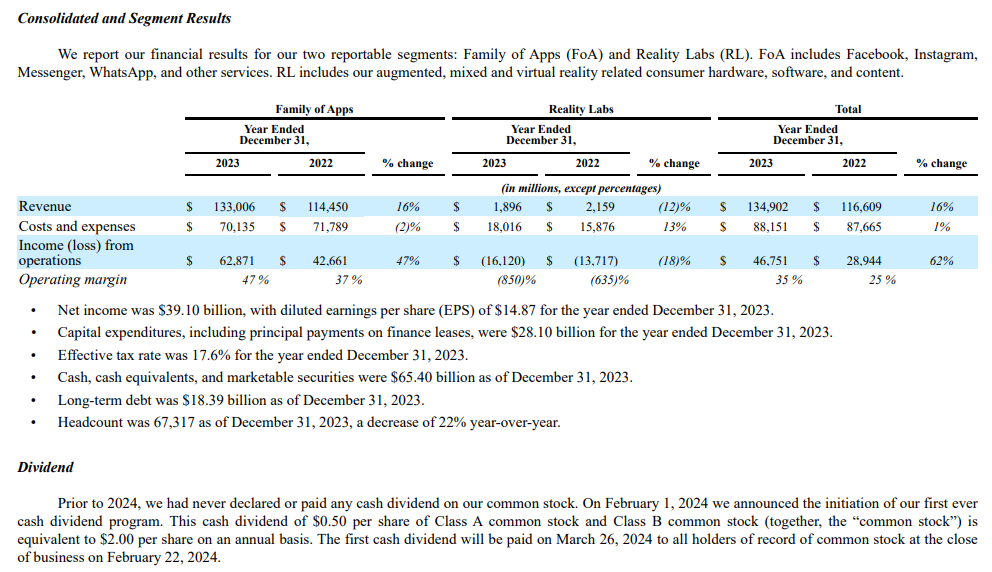

In [91]:
path_img = local_path+"meta_10k_revenue_page60.png"
from IPython.display import Image
Image(path_img)

Good answer:

In [73]:
response = query_engine.query("What was the revenue of Meta on 2022 Year Ended December 31?")
print(str(response))

The revenue of Meta for the year ended December 31, 2022, was $116,609 million.


Sometimes I get the right answer with one call:

In [35]:
response = query_engine.query("What was the revenue of Meta on 2023 Year Ended December 31?")
print(str(response))

The revenue of Meta for the year ended December 31, 2023, was $134,902 million.


Sometimes I have to explicitly specify the page with the required value....not efficient ==> but it's more an issue about retrieval data than parsing data ==> we have seen that the value is included in the parsed data.

In [79]:
response = query_engine.query("What was the revenue of Meta for the year ended December 31, 2023?")
print(str(response))

The revenue of Meta for the year ended December 31, 2023, is not explicitly stated in the provided information.


In [78]:
response = query_engine.query("What was the revenue of Meta for the year ended December 31, 2023 look at page 60?")
print(str(response))

The revenue of Meta for the year ended December 31, 2023, was $134,902 million.


## MAP: Monthly Active People WW

In [17]:
print(page_nodes[65].get_content())

Table of Contents

• Monthly Active People (MAP). We define a monthly active person as a registered and logged-in user of one or more Family products who visited at least one of these Family products through a mobile device application or using a web or mobile browser in the last 30 days as of the date of measurement. We do not require people to use a common identifier or link their accounts to use multiple products in our Family, and therefore must seek to attribute multiple user accounts within and across products to individual people. Our calculations of MAP rely upon complex techniques, algorithms, and machine learning models that seek to estimate the underlying number of unique people using one or more of these products, including by matching user accounts within an individual product and across multiple products when we believe they are attributable to a single person, and counting such group of accounts as one person. As these techniques and models require significant judgment, 

And the image: ⬇ 🔽

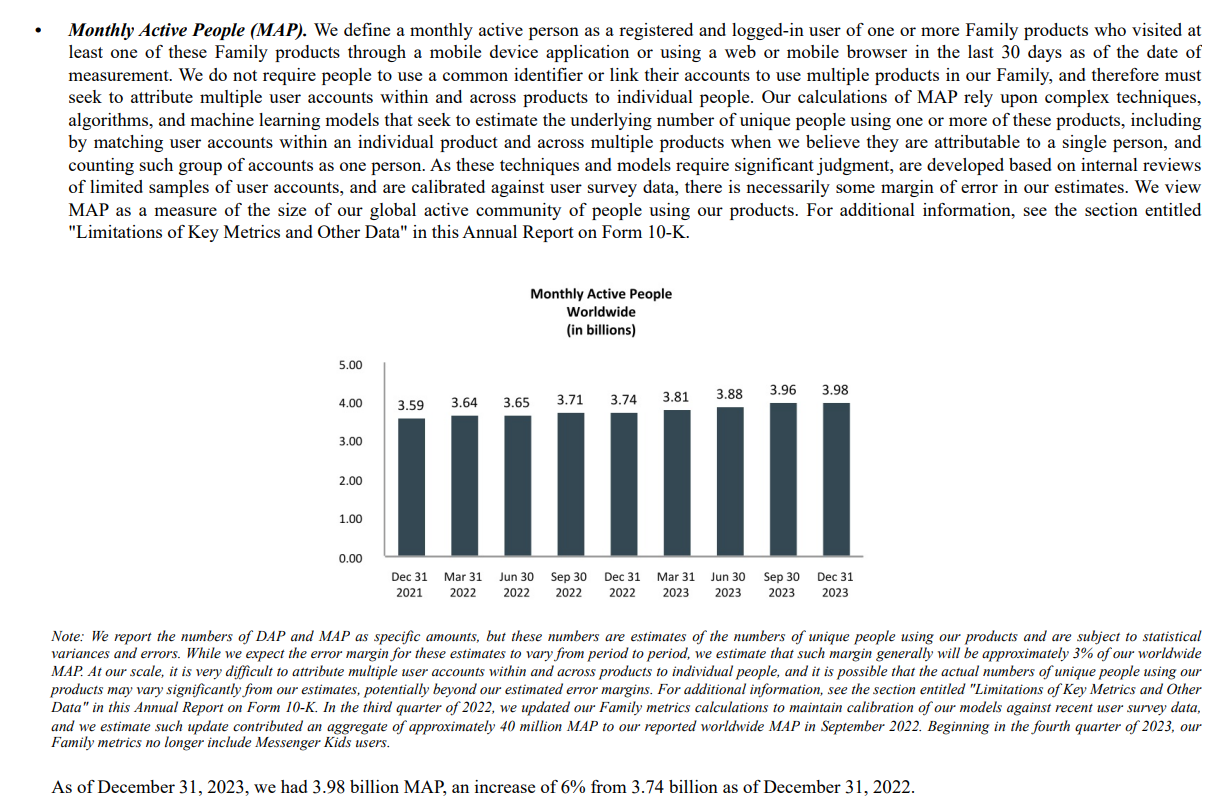

In [93]:
path_img = local_path+"meta_10k_MAP_page65.png"
from IPython.display import Image
Image(path_img)

In [36]:
response = query_engine.query("What was MAP in 31 dec 2021?")
print(str(response))

The Monthly Active People (MAP) on December 31, 2021, was 3.59 billion.


In [81]:
response = query_engine.query("What was MAP in 31 Mar 2023?")
print(str(response))

The Monthly Active People (MAP) on March 31, 2023, was 3.81 billion.


## MAU: Monthly Active Users

In [16]:
print(page_nodes[68].get_content())

Table of Contents

Worldwide DAUs increased 6% to 2.11 billion on average during December 2023 from 2.00 billion during December 2022. Users in India, Bangladesh, and Nigeria represented the top three sources of growth in DAUs during December 2023, relative to the same period in 2022.

* Monthly Active Users (MAUs). We define a monthly active user as a registered and logged-in Facebook user who visited Facebook through our website or a mobile device, or used our Messenger application (and is also a registered Facebook user), in the last 30 days as of the date of measurement. MAUs are a measure of the size of our global active user community on Facebook.

| Monthly Active Users Worldwide (in millions) |
|----------------------------------------------|
| Dec 31 2021 | 2,912 |
| Mar 31 2022 | 2,936 |
| Jun 30 2022 | 2,934 |
| Sep 30 2022 | 2,958 |
| Dec 31 2022 | 2,963 |
| Mar 31 2023 | 2,989 |
| Jun 30 2023 | 3,030 |
| Sep 30 2023 | 3,049 |
| Dec 31 2023 | 3,065 |

| Monthly Active Users

And the image: ⬇ 🔽

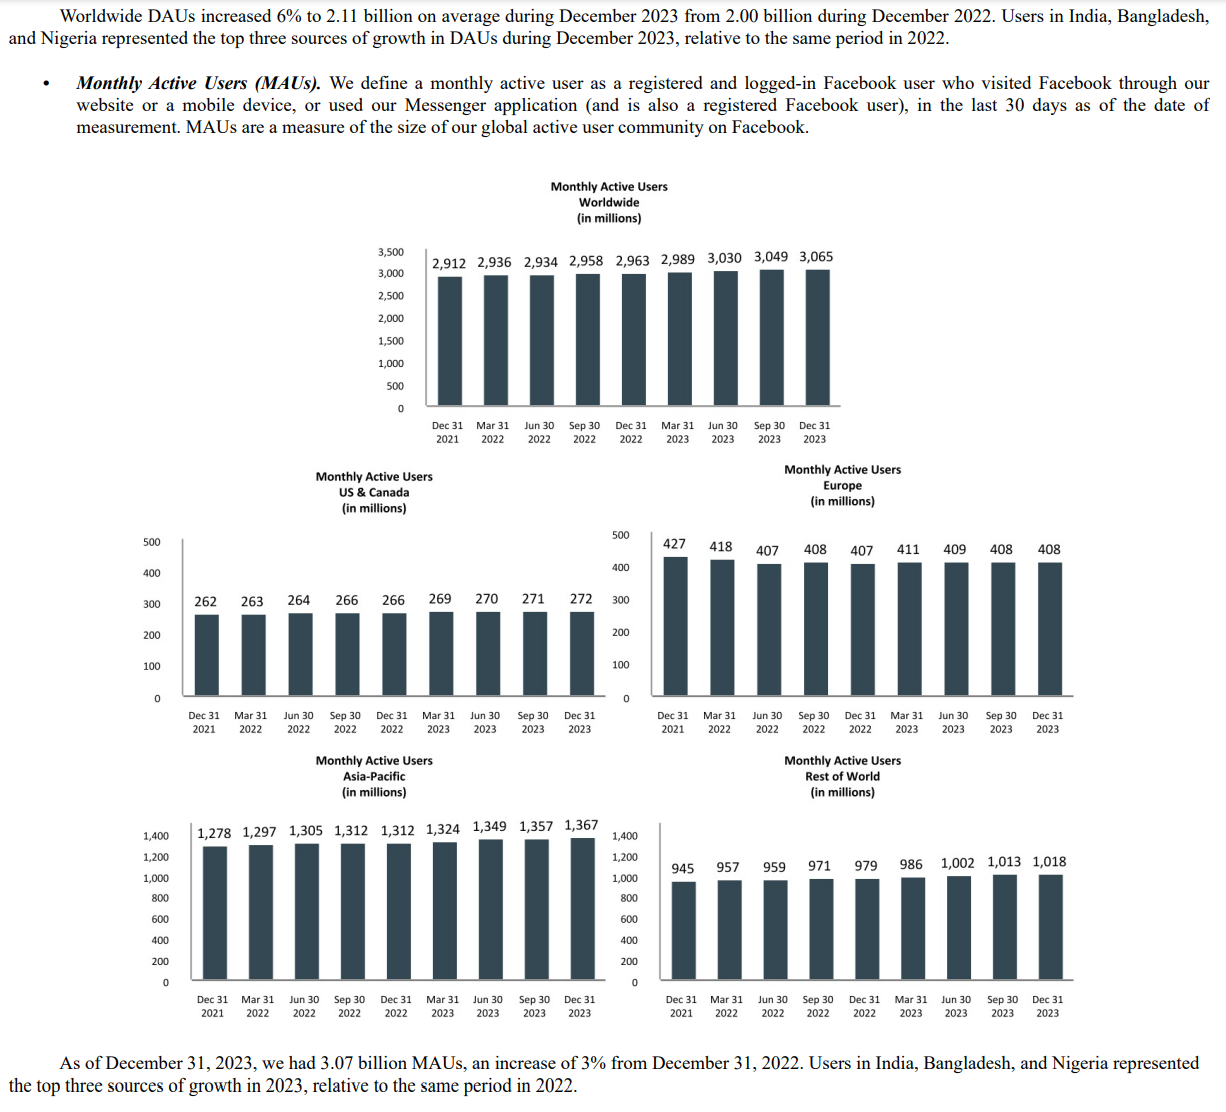

In [94]:
path_img = local_path+"meta_10k_MAP_page68.png"
from IPython.display import Image
Image(path_img)

In [39]:
response = query_engine.query(
    "What was MAu in 31 Mar 2023?"
)
print(str(response))

The Monthly Active Users (MAUs) on March 31, 2023, were 2,989 million.


In [41]:
response = query_engine.query(
    "What was MAU Europe in 31 Sept 2022?"
)
print(str(response)) #even if I type a wrong date (31 instead of 30)

The Monthly Active Users (MAUs) in Europe on September 30, 2022, was 408 million.


In [40]:
response = query_engine.query(
    "What was MAU Rest of world in 31 Dec 2023?"
)
print(str(response))

The Monthly Active Users (MAUs) for the Rest of World as of December 31, 2023, was 1,018 million.


## The following page is much more complicated

The image: ⬇ 🔽

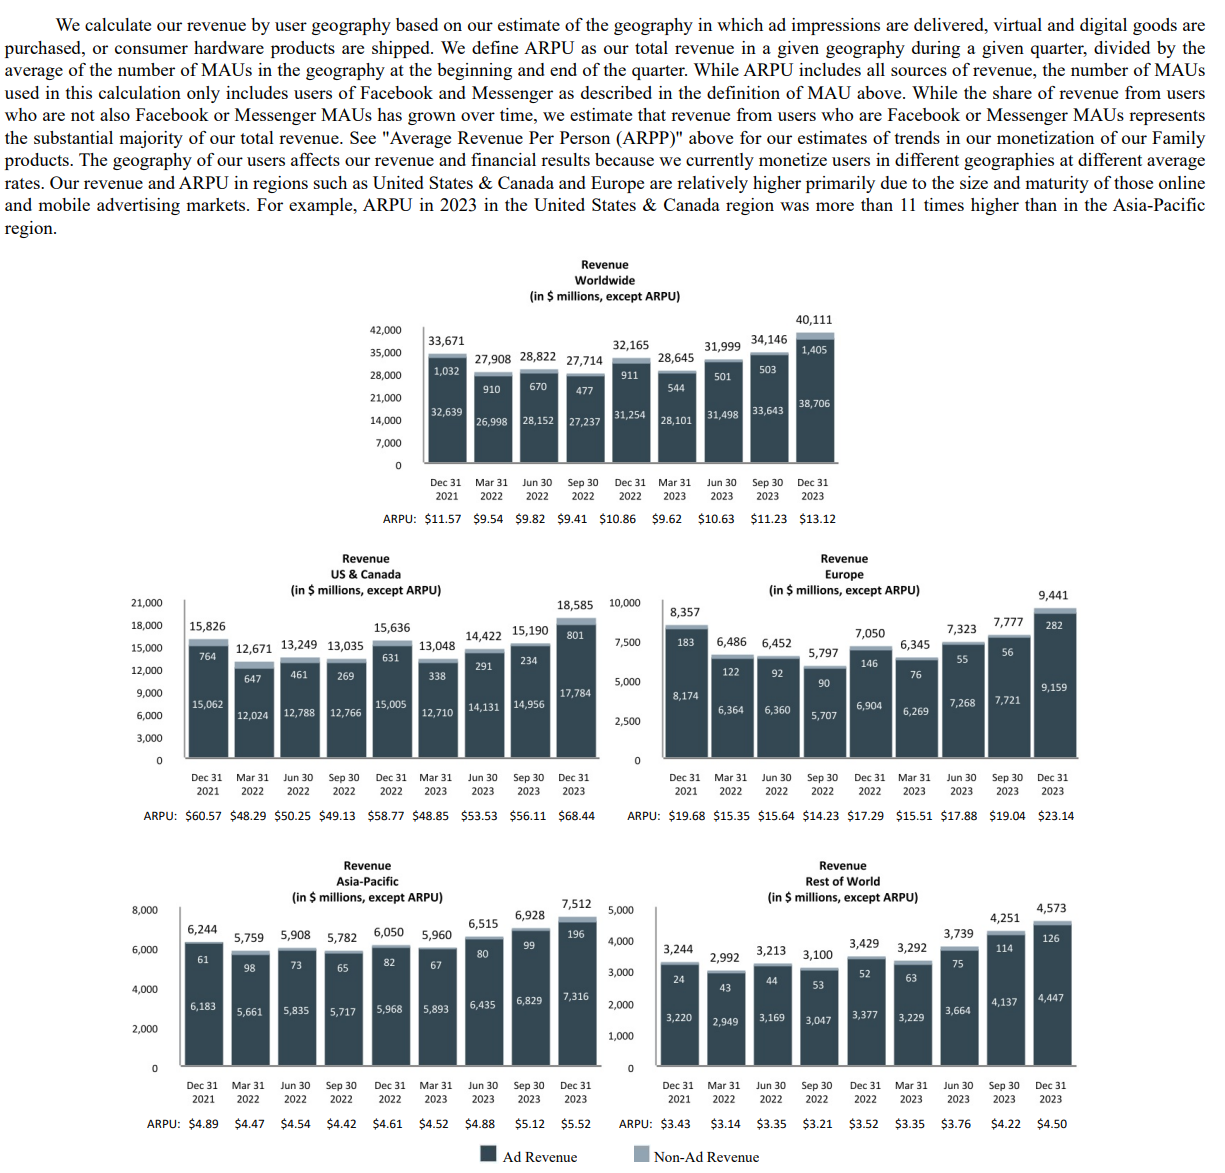

In [96]:
path_img = local_path+"meta_10k_graph_bar_page69.png"
from IPython.display import Image
Image(path_img)

As you can see, very WELL extracted data from the charts:

In [15]:
print(page_nodes[69].get_content())

Table of Contents

## Trends in Our Monetization by Facebook User Geography

We calculate our revenue by user geography based on our estimate of the geography in which ad impressions are delivered, virtual and digital goods are purchased, or consumer hardware products are shipped. We define ARPU as our total revenue in a given geography during a given quarter, divided by the average of the number of MAUs in the geography at the beginning and end of the quarter. While ARPU includes all sources of revenue, the number of MAUs used in this calculation only includes users of Facebook and Messenger as described in the definition of MAU above. While the share of revenue from users who are not also Facebook or Messenger MAUs has grown over time, we estimate that revenue from users who are Facebook or Messenger MAUs represents the substantial majority of our total revenue. See "Average Revenue Per Person (ARPP)" above for our estimates of trends in our monetization of our Family products. The g

In [45]:
response = query_engine.query("What was the revenue worldwide except ARPU during Dec 2023?")
print(str(response))

The revenue worldwide in December 2023 was $40,111 million.


In [46]:
response = query_engine.query("What was the Ad revenue worldwide except ARPU during Dec 2023?")
print(str(response))

The Ad revenue worldwide in December 2023 was $38,706 million.


In [47]:
response = query_engine.query("What was the non Ad revenue Europe during Sept 2023?")
print(str(response))

The non-ad revenue for Europe during September 2023 was $56 million.


# Advanced RAG pipelines : With SummaryIndex, VectorStoreIndex and Router

In this section, I utilized two types of indexes: the **SummaryIndex** for summarizing content and the **VectorStoreIndex** for retrieving relevant chunks based on user queries.

Additionally, I implemented a **router** to determine which index to use based on the nature of the user query

In [82]:
######## Summary and Vector Index ########
from llama_index.core import SummaryIndex, VectorStoreIndex
summary_index = SummaryIndex(page_nodes)
vector_index = VectorStoreIndex(page_nodes)

# Query engine
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True,
)
vector_query_engine = vector_index.as_query_engine()

# Query tool
from llama_index.core.tools import QueryEngineTool

summary_tool = QueryEngineTool.from_defaults(
    query_engine=summary_query_engine,
    description=(
        "Useful for summarization questions related to Meta Financial Report 10k."
    ),
)

vector_tool = QueryEngineTool.from_defaults(
    query_engine=vector_query_engine,
    description=(
        "Useful for retrieving specific context from the Meta Financial Report 10k."
    ),
)

# Selectors
from llama_index.core.query_engine.router_query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector

# Define Router Query Engine
query_engine = RouterQueryEngine(
    selector=LLMSingleSelector.from_defaults(),
    query_engine_tools=[
        summary_tool,
        vector_tool,
    ],
    verbose=True
)

## Chat with GPT-4o-mini

In [83]:
response = query_engine.query("What was the Ad revenue worldwide except ARPU during Dec 2023?")
print(str(response))

Selecting query engine 1: The question asks for specific context regarding Ad revenue, which aligns with retrieving specific information from the financial report..
The Ad revenue worldwide during December 2023 was $38,706 million.


⬆ 🔼 You can check this answer with the results from above ⬆ 🔼



---



In [84]:
response = query_engine.query("Summarize the charts describing the revenue by user geography?")
print(str(response))

Selecting query engine 0: The question asks for a summary of charts, which aligns with the purpose of choice 1 that is useful for summarization questions..
The revenue by user geography for Meta Platforms, Inc. for the year ended December 31, 2023, is as follows:

1. **United States and Canada**: Generated $52.89 billion, which represents a slight increase from $50.15 billion in 2022.
2. **Europe**: Revenue increased to $31.21 billion from $26.68 billion in 2022.
3. **Asia-Pacific**: Revenue rose significantly to $36.15 billion, up from $27.76 billion in 2022.
4. **Rest of World**: Revenue also increased to $14.65 billion, compared to $12.02 billion in 2022.

Overall, the total revenue for 2023 was $134.90 billion, reflecting growth across all geographic regions compared to the previous year.


⬇ 🔽 Awesome!!! Here is the content of the page where this data was retrieved from: ⬇ 🔽

In [85]:
print(page_nodes[103].get_content())

Table of Contents

## Note 2. Revenue

Revenue disaggregated by revenue source and by segment consists of the following (in millions):

| | Year Ended December 31, | | |
|---|---:|---:|---:|
| | 2023 | 2022 | 2021 |
| Advertising | $131,948 | $113,642 | $114,934 |
| Other revenue | 1,058 | 808 | 721 |
| Family of Apps | 133,006 | 114,450 | 115,655 |
| Reality Labs | 1,896 | 2,159 | 2,274 |
| Total revenue | $134,902 | $116,609 | $117,929 |

Revenue disaggregated by geography, based on the addresses of our customers, consists of the following (in millions):

| | Year Ended December 31, | | |
|---|---:|---:|---:|
| | 2023 | 2022 | 2021 |
| United States and Canada(1) | $52,888 | $50,150 | $51,541 |
| Europe(3) | 31,210 | 26,681 | 29,057 |
| Asia-Pacific(2) | 36,154 | 27,760 | 26,739 |
| Rest of World(3) | 14,650 | 12,018 | 10,592 |
| Total revenue | $134,902 | $116,609 | $117,929 |

(1) United States revenue was $49.78 billion, $47.20 billion, and $48.38 billion for the years ended Decem

And the image: ⬇ 🔽

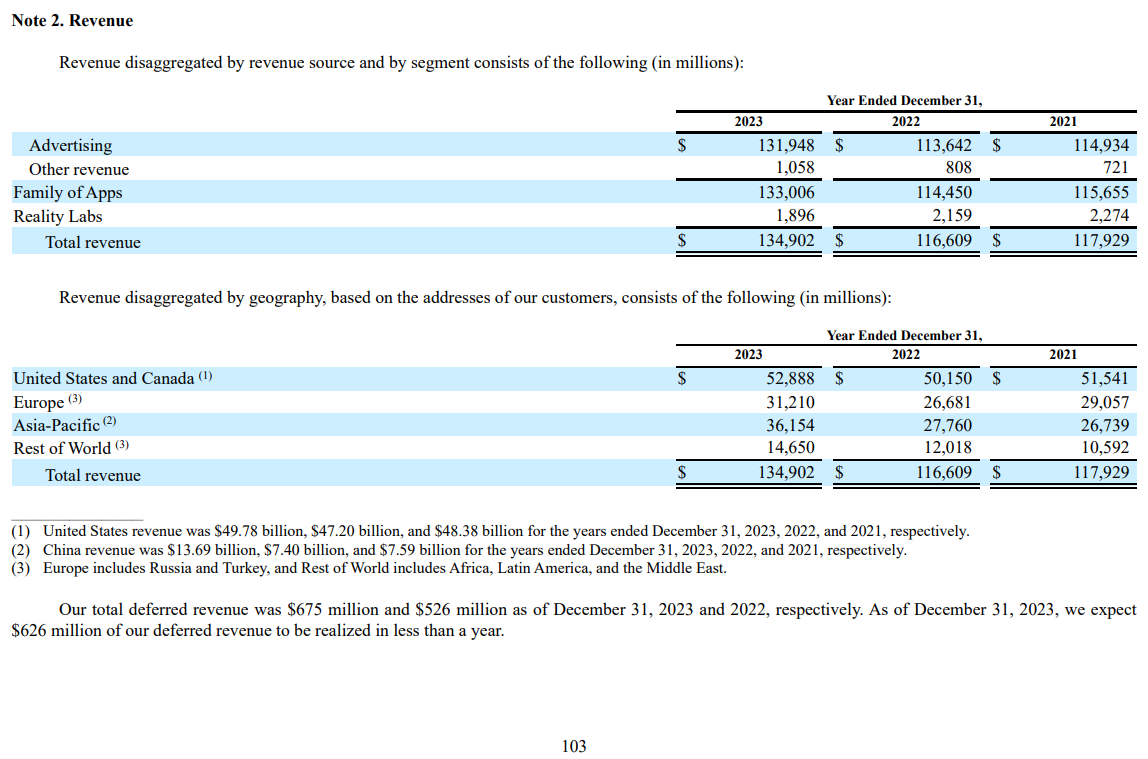

In [97]:
path_img = local_path+"meta_10k_revenue_page103.png"
from IPython.display import Image
Image(path_img)

# Cost

In [ ]:
# $0.00363996 ==> embeddings
# $0.02003490 ==> gpt-4o-mini-2024-07-18, inputs
# $0.00039480 ==> gpt-4o-mini-2024-07-18, outputs

# Key Takeaways:

*   **Precision**: AutoMode clearly indicates which pages are processed with advanced parsing.
*   **Effectiveness**: Data is accurately extracted, even from complex charts.
*   **Efficiency**: RAG pipelines deliver excellent results when paired with high-quality input data.



> This workflow showcases the power of combining smart parsing, LLMs, and tailored RAG pipelines to tackle complex documents.




# Bonus

Sign up for the waitlist to get notified when the AI Agents in Finance course launches:

https://machinelearning-basics.com/ai-agent-in-finance/